## Prepare training data

In [6]:
import csv
import tensorflow as tf
import numpy as np
import os
import pathlib
import shutil
from sklearn.metrics import classification_report

FAST_RUN = False
epochs=1000
print(tf.config.list_physical_devices('GPU'))

def symlink_or_copy(src, dst): #windows sucks and it's easier to copy data
    if os.name == 'nt': 
        if os.path.isfile(src):
            shutil.copy(src,dst)
        else:
            shutil.copytree(src, dst)
    else:
        os.symlink(src,dst)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
input_path = "./kaggle/input/plant-pathology-2021-fgvc8/"
dataset_path = "./kaggle/working/dataset/"
checkpoint_filepath = './tmp/checkpoint'
model_filepath = './model'
test_path = "./kaggle/working/test/"
result_path = "./kaggle/working/submission.csv"
all_image_paths = []
all_image_labels = []

with open(input_path + 'train.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    first_row = True
    for row in csv_reader:
        ################## fast test only
        if FAST_RUN and len(all_image_paths) > 100:
            break
        ###################
        if not first_row:
            all_image_paths.append(input_path + 'train_images/' + row[0])
            all_image_labels.append(row[1])
        first_row = False
        
labels_set = set(all_image_labels)
print(all_image_paths[:3])
print(all_image_labels[:3])
print(labels_set)

['./kaggle/input/plant-pathology-2021-fgvc8/train_images/800113bb65efe69e.jpg', './kaggle/input/plant-pathology-2021-fgvc8/train_images/8002cb321f8bfcdf.jpg', './kaggle/input/plant-pathology-2021-fgvc8/train_images/80070f7fb5e2ccaa.jpg']
['healthy', 'scab frog_eye_leaf_spot complex', 'scab']
{'scab frog_eye_leaf_spot', 'healthy', 'scab frog_eye_leaf_spot complex', 'frog_eye_leaf_spot complex', 'rust frog_eye_leaf_spot', 'scab', 'rust', 'powdery_mildew complex', 'powdery_mildew', 'complex', 'frog_eye_leaf_spot', 'rust complex'}


In [8]:
for label in labels_set:
    shutil.rmtree(dataset_path + label, ignore_errors=True)
    pathlib.Path(dataset_path + label).mkdir(parents=True)

for i in range(len(all_image_paths)):
    symlink_or_copy(all_image_paths[i], all_image_paths[i].replace(input_path + "train_images", dataset_path + all_image_labels[i]))

## Load training data

In [9]:
batch_size = 128
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18632 files belonging to 12 classes.
Using 14906 files for training.
Found 18632 files belonging to 12 classes.
Using 3726 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

val_labels = []
for x, y in val_ds:
    val_labels.append(y)
val_labels = np.concatenate(val_labels)  
print(val_labels[:3])

['complex', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot complex', 'healthy', 'powdery_mildew', 'powdery_mildew complex', 'rust', 'rust complex', 'rust frog_eye_leaf_spot', 'scab', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot complex']
[ 0 10  6]


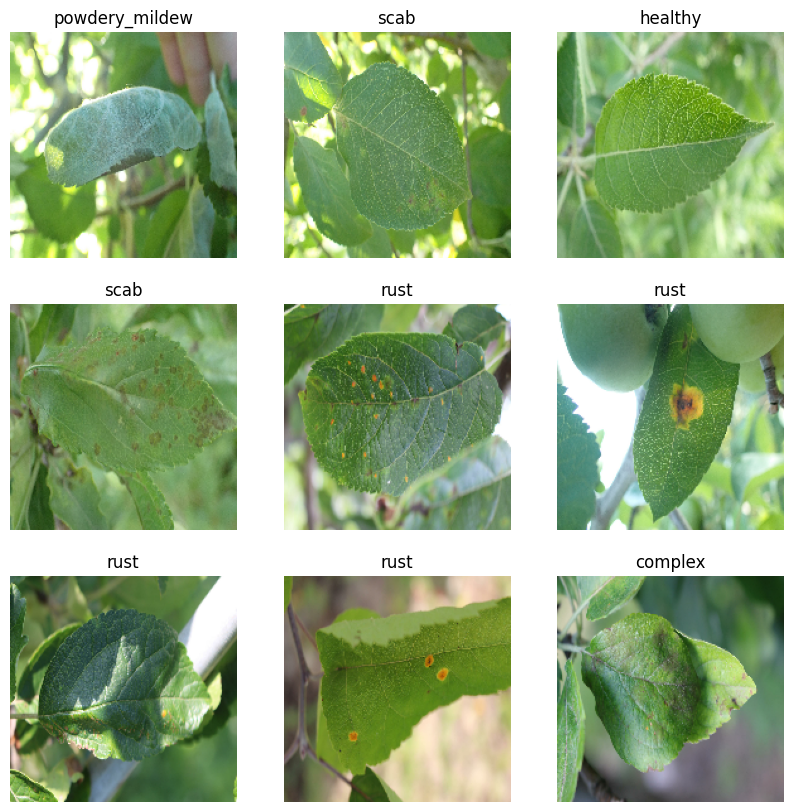

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  )
model.build(input_shape=(None, 180, 180, 3))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

## Train data

In [13]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1,
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, 
                save_weights_only=True,
                monitor='val_loss',
                mode='max',
                save_best_only=True,
                verbose=1),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=10,verbose=1),
              tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=6,
                verbose=0,
                mode='auto',
                min_delta=0.001,
                cooldown=0,
                min_lr=1e-9,
            )
            ],
  verbose=1
)

model.load_weights(checkpoint_filepath) 
model.save(model_filepath)

117/117 [==============================] - ETA: 0s - loss: 1.6852 - accuracy: 0.3734
Epoch 1: val_loss improved from -inf to 1.50994, saving model to ./tmp\checkpoint
117/117 [==============================] - 140s 1s/step - loss: 1.6852 - accuracy: 0.3734 - val_loss: 1.5099 - val_accuracy: 0.4635 - lr: 0.0010


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


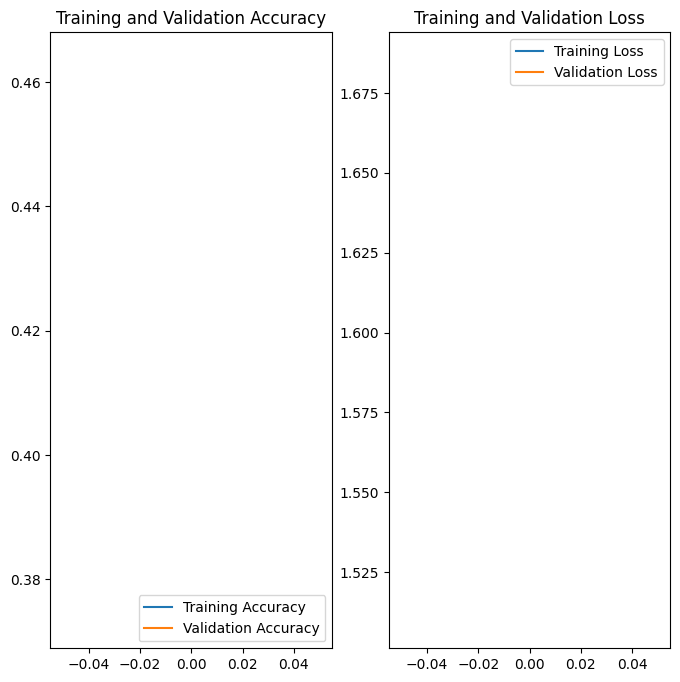

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
predicted_val_labels = np.argmax(model.predict(val_ds), axis=1)
print("Validataion metrics")

30/30 [==============================] - 24s 582ms/step
Validataion metrics


In [16]:
print(classification_report(val_labels,predicted_val_labels))
report = classification_report(val_labels,predicted_val_labels, output_dict=True)
f1_scores = [report[str(class_idx)]['f1-score'] for class_idx in range(num_classes)]
print(f"validation mean f1-score: {sum(f1_scores)/len(f1_scores)}")
print(f"validation accuracy {report['accuracy']}")

              precision    recall  f1-score   support

           0       0.09      0.09      0.09       305
           1       0.16      0.13      0.15       629
           2       0.00      0.00      0.00        30
           3       0.24      0.36      0.29       927
           4       0.07      0.04      0.06       248
           5       0.00      0.00      0.00        11
           6       0.08      0.10      0.09       363
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        27
           9       0.26      0.25      0.25       978
          10       0.00      0.00      0.00       146
          11       0.00      0.00      0.00        42

    accuracy                           0.20      3726
   macro avg       0.08      0.08      0.08      3726
weighted avg       0.18      0.20      0.18      3726

validation mean f1-score: 0.0771369355769111
validation accuracy 0.1977992485238862


c:\repos\liscie\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\repos\liscie\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\repos\liscie\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\repos\liscie\.venv\lib\site-packages\sklearn\metrics\_classif

## Test prediction

In [17]:
shutil.rmtree(test_path, ignore_errors=True)
pathlib.Path(test_path).mkdir(parents=True)

symlink_or_copy(input_path + "test_images/", test_path + "test")

In [18]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3 files belonging to 1 classes.


In [19]:
label_ids = np.argmax(model.predict(test_ds), axis=1)

output = "image,labels\n"
for i in range(len(label_ids)):
    output += test_ds.file_paths[i].replace(test_path + "test/", "") + "," + class_names[label_ids[i]] + "\n"
print(output)
f = open(result_path, "w")
f.write(output)
f.close()

1/1 [==============================] - 0s 168ms/step
image,labels
./kaggle/working/test/test\ad8770db05586b59.jpg,rust
./kaggle/working/test/test\c7b03e718489f3ca.jpg,complex
./kaggle/working/test/test\85f8cb619c66b863.jpg,frog_eye_leaf_spot

